In [1]:
import tensorflow as tf
import imageio
import numpy as np

import os
import glob
import time

import PIL
import imageio
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

# EX11 GAN  
## Objective  
1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.  
오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.  
2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.  
gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.  
3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.  
모델구조 변경 혹은 학습과정 개선 아이디어를 추가적으로 적용해보았고, 적용 전과 비교하였을 때의 내용을 표와 같은 시각적 자료로 작성하였다.  

### 데이터 다운로드 및 정규화  
cifar-10 dataset을 사용합니다

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, train_y), (test_x, test_y) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [3]:
train_x.max()

255

In [4]:
train_x[0].shape

(32, 32, 3)

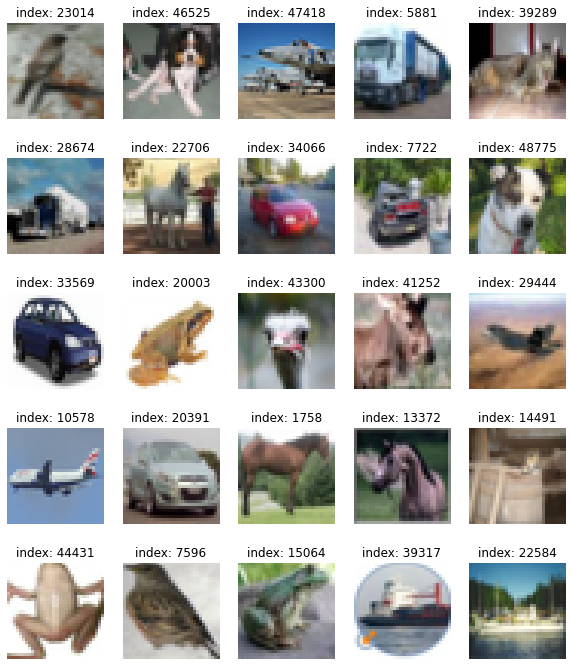

In [5]:
plt.figure(figsize=(10, 12))

random_index = []
for i in range(25):
    random_index.append(np.random.randint(1, 50000))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_x[random_index[i]])
    plt.title(f'index: {random_index[i]}')
    plt.axis('off')

plt.show()

In [6]:
train_x = (train_x - 127.5) / 127.5

In [7]:
train_x.max()

1.0

In [8]:
train_x.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

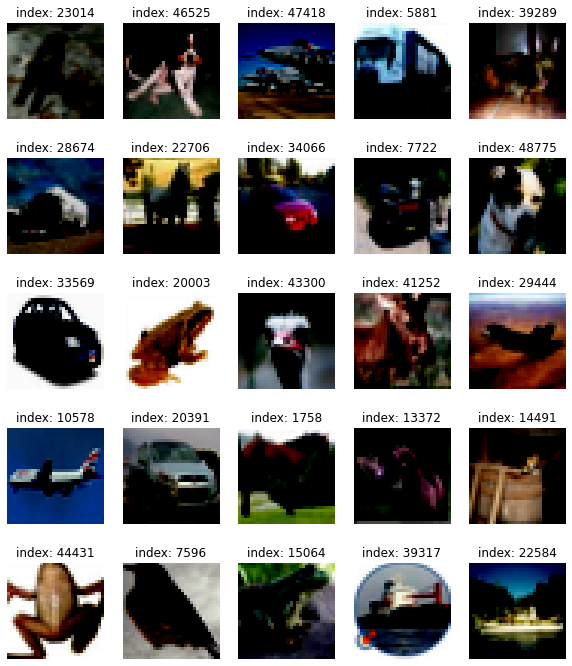

In [9]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_x[random_index[i]])
    plt.title(f'index: {random_index[i]}')
    plt.axis('off')

plt.show()

기존의 0 ~ 127 => -1  ~ 0 => 0 ~ 0  
128 ~ 255의 =? 0 ~ 1 => 0~ 255  
의 연산을 거치며, 이미지가 전체적으로 어두워지고 대비효과가 생긴것으로 예측됩니다

### 미니배치 구성

In [10]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### 모델 설계  
생성자 판별자를 만듭니다 

In [12]:
def make_generator_model():
    
    #이미지 사이즈 32 * 32
    #8*8 > 16*16 > 32 * 32
    #초기값은 8*8, 처음 Dense layer과 reshape layer에 적용하도록 합니다

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
    
    #마지막 레이어는 채널이 3개라 3으로 바꿔줌

    return model

생성자가 잘 만들어졌는지 확인해보겠습니다

In [13]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [14]:
noise = tf.random.normal([1, 100])

In [15]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

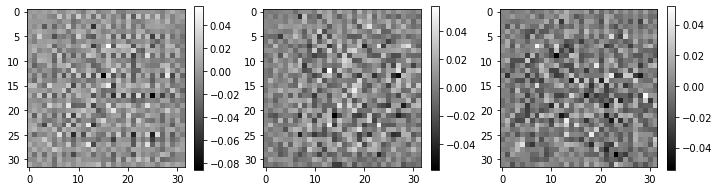

In [16]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(generated_image[0, :, :, 1], cmap='gray')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(generated_image[0, :, :, 2], cmap='gray')
plt.colorbar()

plt.show()

생성자 모델을 통해 생성된 이미지의 각 채널입니다  
채널마다 각기 다른 초기 노이즈를 보여줍니다  

In [17]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    #철 레이어는 채널이 3개라 input shape 3으로 바꿔줌
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [18]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [19]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[8.481264e-05]], dtype=float32)>

생성자 모델에서 만든 이미지를 판별자 모델에서 테스트했습니다  
두 모델이 생성 / 판별하는 이미지의 형상 (shape)가 맞음을 먼저 확인했습니다  
  
두 모델이 잘 만들어졌음을 확인했으므로, 학습 / 평가를 시작합니다

### 손실함수 설계  
Real Image에 대한 라벨을 1, Fake Image에 대한 라벨을 0이라고 한다면  
생성자는 만든 이미지가 판별자에 의해 1이 되는 방향으로,  
판별자는 진짜 이미지는 1, 가짜 이미지는 0으로 판별을 잘 할 수 있는 방향으로 학습되어야 할것입니다  
결국 두 신경망은 모두 판별자의 판별값을 이용하여 손실함수를 설계하게 됩니다  

In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [23]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### 최적화함수 설계  
생성자와 판별자는 결과만 공유하고 학습은 독립적으로 합니다  
따라서 최적화 함수 또한 각각 만들어 사용해야 합니다

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### 학습상황 점검하기  
고정된 노이즈 벡터를 사용하여, 두 신경망의 학습 정도를 중간중간 체크합니다

In [25]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### 배치학습 구현하기  
함수 데코레이터를 사용합니다  

In [26]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [27]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(10, 12))
    for i in range(predictions.shape[0]):        
        plt.subplot(4, 4, i+1)
        img = predictions[i].numpy()
        img = (img* 127.5) + 127.5 
        img = img.astype(int)
        plt.imshow(img)
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [28]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [29]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### 학습 진행하기  

In [30]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [31]:
save_every = 5
EPOCHS = 300

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

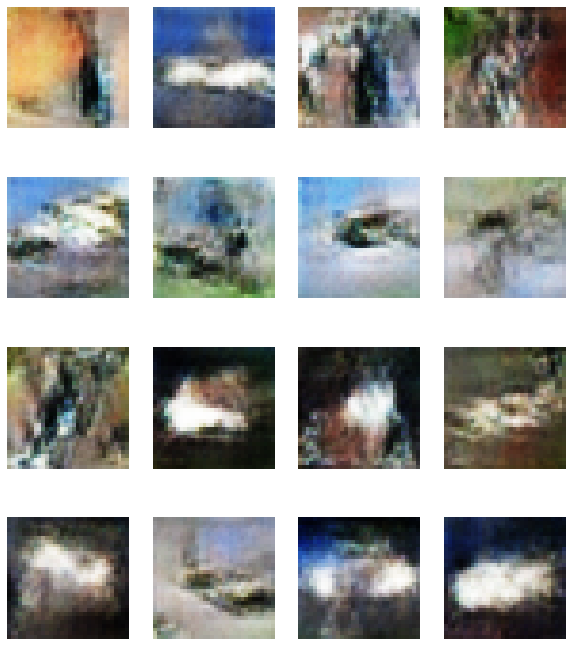

Time for training : 5095 sec


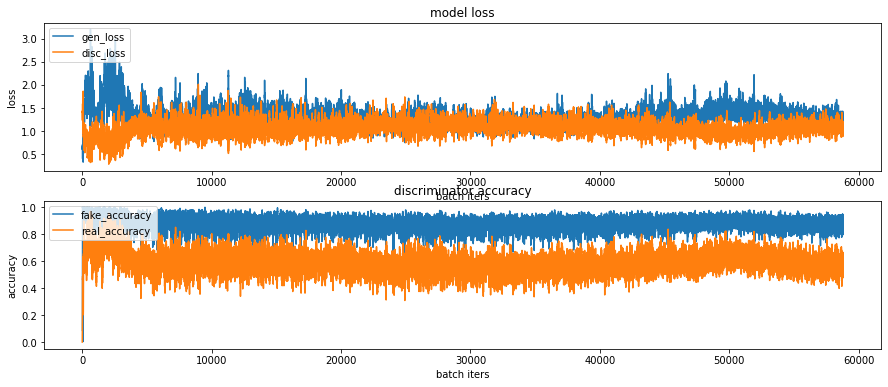

CPU times: user 1h 26min 33s, sys: 7min 48s, total: 1h 34min 22s
Wall time: 1h 24min 58s


In [32]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

Discriminator 의 fake accuracy가 0.8~1에서 진동을 유지하고 있습니다  
이는 곧, Generater가 제대로 Discriminator를 속이지 못하고 있다 할 수 있습니다  

또한 이미지에서 유사성이 크게 보여, mode collapsing 상태에 들어섰다고 할 수 있겠습니다

제시된 아이디어들은 Gan의 창시자 및 다른 여러포스트에서 제안하는 퍼포먼스 개선방안입니다

Normalize inputs to the range [-1, 1] and use tanh in the generator output.  
Flip the labels and loss function when training the generator.  
Sample Gaussian random numbers as input to the generator.  
Use mini batches of all real or all fake for calculating batch norm statistics.  
Use Leaky ReLU in the generator and discriminator.  
Use Average pooling and stride for downsampling; use ConvTranspose2D and stride for upsampling.  
Use label smoothing in the discriminator, with small random noise.  
Add random noise to the labels in the discriminator.  
Use DCGAN architecture, unless you have a good reason not to.  
Add noise to inputs to the discriminator and decay the noise over time.  
Use dropout of 50 percent during train and generation.  
  
https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/  

이 중 몇가지 방안은 기존모델에서 사용중입니다

Normalize inputs to the range [-1, 1] and use tanh in the generator output.  
Use Leaky ReLU in the generator and discriminator.  
Use DCGAN architecture, unless you have a good reason not to.  
Use Average pooling and stride for downsampling; use ConvTranspose2D and stride for upsampling.  
Sample Gaussian random numbers as input to the generator.  

나머지 방안 중 몇 개을 채용해서 다시 모델을 짜보도록 합니다

Use dropout of 50 percent during train and generation.  
Use label smoothing in the discriminator, with small random noise.  

나머지 방안은 추후에 시도해보겠습니다  
Use mini batches of all real or all fake for calculating batch norm statistics.  
Flip the labels and loss function when training the generator.  
Add random noise to the labels in the discriminator.
Add noise to inputs to the discriminator and decay the noise over time.  
Use labels if you have them (conditional GAN information : https://engineer-mole.tistory.com/49)

In [65]:
#from scipy.stats import truncnorm

#def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
#    return truncnorm(
#        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

#rand_gauss = get_truncated_normal(0, 0.5, -1, 1)

#이 코드가 앞으로 노이즈를 생성하는 코드가 됩니다
#gauss_noise = rand_gauss.rvs(100)

#print(gauss_noise)
#plt.hist(gauss_noise)
#plt.show()

#참고 :https://stackoverflow.com/questions/36894191/how-to-get-a-normal-distribution-within-a-range-in-numpy

### loss function에 label smoothing 적용

In [116]:
def refined_discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) * 0.9, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# https://blog.si-analytics.ai/21

### 모델 구조 변경

생성자에 dropout 레이어 생성, 0.5 적용
판별자의 dropout 레이어 수치는 총합이 이미 0.51 같군요  
https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/  
에 의하면 생성자 모델에 드랍아웃 추가 시, 제일 마지막 출력 전에 dropout을 적용했습니다  
저는 판별자의 기존 예시코드대로, 각 레이어에서 drop을 하여 최종 dropout합이 0.5에 근사하도록 설정하겠습니다  
( (1-0.2) **3 = 0.512 )  


In [98]:
def refined_make_generator_model():
    
    #이미지 사이즈 32 * 32
    #8*8 > 16*16 > 32 * 32
    #초기값은 8*8, 처음 Dense layer과 reshape layer에 적용하도록 합니다

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #추가
    model.add(layers.Dropout(0.2))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #추가
    model.add(layers.Dropout(0.2))
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #추가
    model.add(layers.Dropout(0.2))
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
    
    #마지막 레이어는 채널이 3개라 3으로 바꿔줌

    return model

학습 파라메터도 변화를 줍니다

In [99]:
save_every = 5
EPOCHS = 500
BUFFER_SIZE = 50000
BATCH_SIZE = 128

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

데이터셋과, train 관련 함수들 또한 새로운 환경에 맞추어 변경해야 합니다  

In [100]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [118]:
@tf.function

def refined_train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = refined_discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [119]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(10, 12))
    for i in range(predictions.shape[0]):        
        plt.subplot(4, 4, i+1)
        img = predictions[i].numpy()
        img = (img* 127.5) + 127.5 
        img = img.astype(int)
        plt.imshow(img)
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/refined_generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [120]:
refined_checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/refined/training_checkpoints'

refined_checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
refined_checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [121]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def refined_draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/refined_training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [122]:
def refined_train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = refined_train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                refined_generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=refined_checkpoint_prefix)

        display.clear_output(wait=True)
        refined_generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        refined_draw_train_history(history, epoch)

In [123]:
generator = refined_make_generator_model()

generator.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_13 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 16384)             0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_14 (Batc (None, 8, 8, 128)        

In [124]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)            

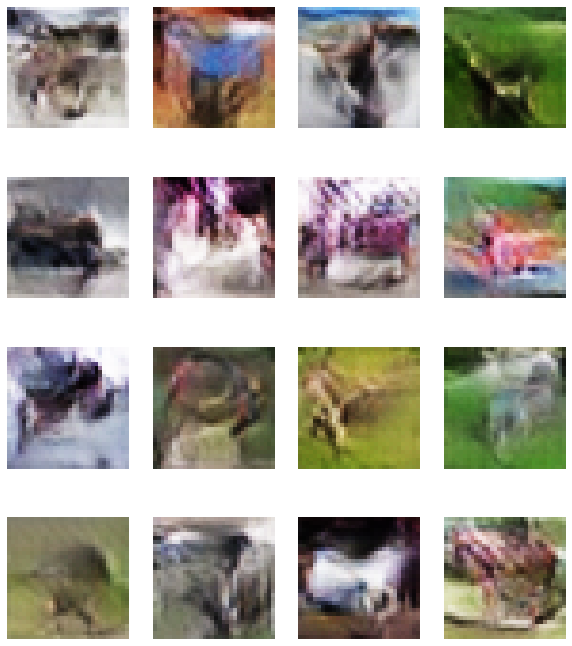

Time for training : 7751 sec


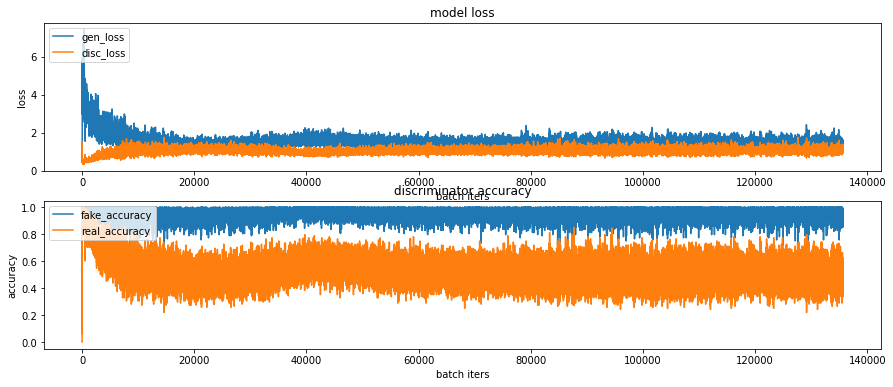

In [ ]:
refined_train(train_dataset, EPOCHS, save_every)


한참 에폭을 진행중이지만, 개선점을 만드는 데에는 실패한듯이 보입니다  
만들어지는 이미지도 3~4개의 객체의 이미지인 듯 합니다  
초기화가 잘못되었을까요?  결국 mode collapsing을 방지하지 못한 듯 합니다  

In [ ]:
#저장 및 로드를 위한 함수들은 잘 동작함을 확인하였습니다

In [59]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)



In [43]:
!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 7027541 Dec 19 13:52 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


In [44]:
history_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_history.gif'

with imageio.get_writer(history_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/training_history/train*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)



In [ ]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator_loaded = checkpoint.generator
discriminator_loaded = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 

num_examples_to_generate = 16
noise_dim = 100
test_seed = tf.random.normal([num_examples_to_generate, noise_dim])
test_result = generator_loaded(test_seed, training=False)

plt.figure(figsize=(10, 12))

for i in range(num_examples_to_generate):
    generated_image_loaded = test_result[i]
    np_generated_image_loaded = generated_image_loaded.numpy()
    np_generated_image_loaded = (np_generated_image_loaded * 127.5) + 127.5 
    np_generated_image_loaded = np_generated_image_loaded.astype(int)
    
    plt.subplot(4, 4, i+1)
    plt.imshow(np_generated_image_loaded)
    plt.title(f'index: {i}')
    plt.axis('off')

plt.show()

#noise = tf.random.normal([1, 100])
#generated_image_2 = generator_loaded(noise, training=False)

#np_generated_2 = generated_image_2.numpy()
#np_generated_2 = (np_generated_2 * 127.5) + 127.5   # reverse of normalization
#np_generated_2 = np_generated_2.astype(int)
#plt.imshow(np_generated_2[0])
#plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

## 회고  
디퓨전 모델은 매우 재밌습니다  
어쩌면 관심사가 바뀔지도 모르겠습니다  
  
### 아쉬운 점  
  
1. lms의 예제를 다시 따라하며 방법을 익히고, 개선점을 찾는 방향으로 학습하다보니  
가끔 기존의 작업을 메모리에서 덮어야 하는 상황이 발생합니다  
잘 짜여진 함수를 활용하기 위해, 같은 변수명을 가진 새로운 인스턴스를 생성하는 경우가 특히 그렇습니다  
혹은 분명 함수이지만 메인코드에서 사용하는 변수를 그대로 글로벌 영역에서 가져와서 구현하는 경우가 그렇습니다  
(코드 내에서는 generator 등의 부분)   
   
실습코드는 교육목적에서 더 잘 표현하기 위해 고려한 구성이라고 생각하기 때문에,   
함수 파라메터를 사용하여 영역을 구분짓는 것, 재사용에 대한 불편함 등은 실습 시 엔지니어링 해야 할 부분이라고 생각합니다   
오늘 코드는 급한 마음에 많은 것을 덮었지만,   
앞으로는 이 시간들이 범용성있게 structure를 구성해보는 연습하는 찬스라고 생각하고 더 신경써서 구분을 짓도록 하겠습니다   
   
2. 모델을 지도에 맞추어 개선했음에도 퍼포먼스가 달라지지 않았습니다   
  
시간과 용량 문제로, 비교적 적은 시간을 쏟을 수 있는 제안만 적용하고,  
더 좋은 변화를 가져올 수 있을법한 제안은 개선에 반영하지 못했습니다   
  
Use mini batches of all real or all fake for calculating batch norm statistics.  
생성자가 만든 배치들을 통쨰로 학습시켜보기  
  
Flip the labels and loss function when training the generator.  
loss function 뒤집기  
일부분 loss function의 (1 - logD)의 부분을 (1 - (1-log D)) 로, 즉 log뒤로 구현할 수 있다고 소개되어 있습니다   
다만, 지금 손실함수의 형태에서는 어떻게 적용할 수 있을 지 감이 오지 않았습니다    
   
Add random noise to the labels in the discriminator.  
Add noise to inputs to the discriminator and decay the noise over time.  
  
Use labels if you have them   
이 부분이 특히 구현에 포함시키지 못해 아쉬운 부분입니다   
(conditional GAN information : https://engineer-mole.tistory.com/49)   
데이터 공간도 많이 필요할거라 예상하는 바, 다른 솔루션이 있다면 더 찾아보도록 하겠습니다   

